## Configuração do Jupyter Nootebook 

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Pacotes Utilizados

In [3]:
import import_ipynb
import random
import sys
import numpy as np
import matplotlib.pylab as plt
#import boris_stepper
from Functions import push_particles

plt.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline

importing Jupyter notebook from Functions.ipynb


### Constantes

In [41]:
c      = 299792458      # speed of light in m/s
dt     = 1e-2           # time step in seconds.
Nsteps = 5000           # number of time steps.
skip   = 1              # output dumping rate.
npart  = 10              # number of particles.
nstd   = 5           # number of standard deviations to be added to the upstream drift velocity v1.

t= np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0 

In [42]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.

muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma   = 5/3

In [43]:
v1 = [-421.458008, -27.801001, 20.910]          # km/s
B1 = [-8.032000, 12.403000, 6.124]              # nT
n1 = 21.268999                                  # cm^-3
T1 = 39.785000                                  # eV
# vetor normal ao plano de choque
n = [0.8921752 ,  0.43381014, -0.12582624]

In [44]:
v1n = np.abs(np.dot(v1,n)*1e3)                       # Velocidade pré-choque normal ao plano de choque        [m/s]
B1n = np.dot(B1,n)                                   # Campo magnético pré-choque normal ao plano de choque   

B1t = np.sqrt(np.linalg.norm(B1)**2 - B1n**2)*1e-9   # Campo magnético pré-choque tangente ao plano de choque [T]

B1u = np.array([0,0,B1t])                            # vetor B1t na direção z

In [45]:
# derived parameters

Eu = -np.cross(np.array([0,v1n,0]),np.array([0,0,B1t]))   #electric field. The same on both sides.
p1 = 2*n1*1e6*1.3806e-23*(T1*1.1604e4)                    #thermal pressure in Pa 
                                                      #(the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)*1e6                                      #particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1t)  #thermal gyroradius in m.

# standard deviation (in m/s) of the distribution: assumed to be a drifting Maxwellian.
std = np.sqrt(2*T1*1.602e-19/(m*me)) 
v1std = v1n + nstd*std # particle speed in m/s

In [46]:
R1

57723.69214019554

In [47]:
std

87302.182721385

In [50]:
# ----------------------------------------
# Loop over the "npart" particles.
# ----------------------------------------
# Boundaries of the simulation box in the X-direction. 
x0lower = -14.0
x0upper =  10.0 
z0lower = -1.0
z0upper = 1.0
# particle initial location in terms of the thermal gyroradius R1
x0 = 0.0
y0 = -4.0*R1 
z0 = 0.0

rx = np.zeros([int(Nsteps/skip)+1,npart])
ry = np.zeros([int(Nsteps/skip)+1,npart])
rz = np.zeros([int(Nsteps/skip)+1,npart])
vx = np.zeros([int(Nsteps/skip)+1,npart]) 
vy = np.zeros([int(Nsteps/skip)+1,npart]) 
vz = np.zeros([int(Nsteps/skip)+1,npart])
ek = np.zeros([int(Nsteps/skip)+1,npart])
mu = np.zeros([int(Nsteps/skip)+1,npart]) 
rL = np.zeros([int(Nsteps/skip)+1,npart])

for i in range(npart):       
    
    r0   = np.array([x0, y0, z0])
    r    = r0
    
    vx0  = v1std*np.sin(((-1)**i)*(i*random.uniform(0,1))*np.pi/50)        
    # vx0  = v1std*np.sin(((-1)**i)*(random.uniform(0,1))*np.pi/50)
     
    vy0  = v1std*np.cos((i*random.uniform(0,1))*np.pi/50)                  
    # vy0  = v1std*np.cos((random.uniform(0,1))*np.pi/50) 
    
    vz0  = v1std*np.sin(((-1)**i)*(i*random.uniform(0,1))*np.pi/50)
    
    v    = np.array([vx0,vy0,vz0])                                           
    # v    = np.array([0,v1,0])
    
    vn = np.linalg.norm(v)
    
    # compression ratio.
    
    em = 0.5*(rho1*(vn**2)+B1t**2/(muo))+p1
    
    zeta =((2*gamma*em-rho1*(vn**2))
    +np.sqrt((2*gamma*em-rho1*(vn**2))**2-4*rho1*(gamma+1)*(gamma-2)*(vn*B1t)**2/muo))/(2*rho1*(gamma+1)*vn**2)  
    #zeta = (rho1*(v1std**2)+4*(p1+B1**2/(2*muo)))/(3*rho1*(v1std**2)) 
    
    # Lorentz's factor
    
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1u))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1u)))

    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
         
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        # left boundary condition
        #if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        #if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
                # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        # down boundary condition
        if r[2] < z0lower*R1: r[2] = r[2] + (np.abs(z0upper)+np.abs(z0lower))*R1
        # up boundary condition
        if r[2] > z0upper*R1: r[2] = r[2] - (np.abs(z0upper)+np.abs(z0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Gráficos

### a)

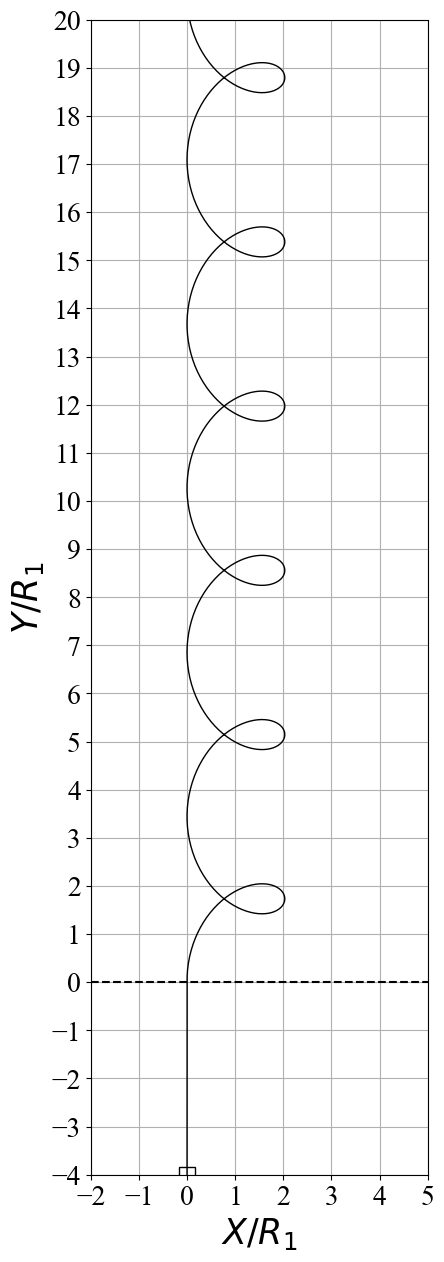

In [30]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

ax.plot(rx/R1, ry/R1, 'k-', lw = 1) 

ax.plot(x0/R1, y0/R1,'sk', markersize=12, markerfacecolor='none', markeredgecolor='black')

ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([y0/R1,20]);
#ax.set_xlim([x0lower,x0upper])
ax.set_xlim([-2,5])

ax.tick_params(axis='both', which='major', labelsize = 20 )

ax.set_xticks(np.arange(-2,5.1,1))
ax.set_yticks(np.arange(-4,20.1,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size=25)
ax.grid(axis='both')
ax.set_aspect(1)

#plt.savefig('SampleTrajectory_07_10_2015_3D_0SIGMA_v1.png',dpi=150, facecolor='w', edgecolor='w', bbox_inches='tight')

### b) 

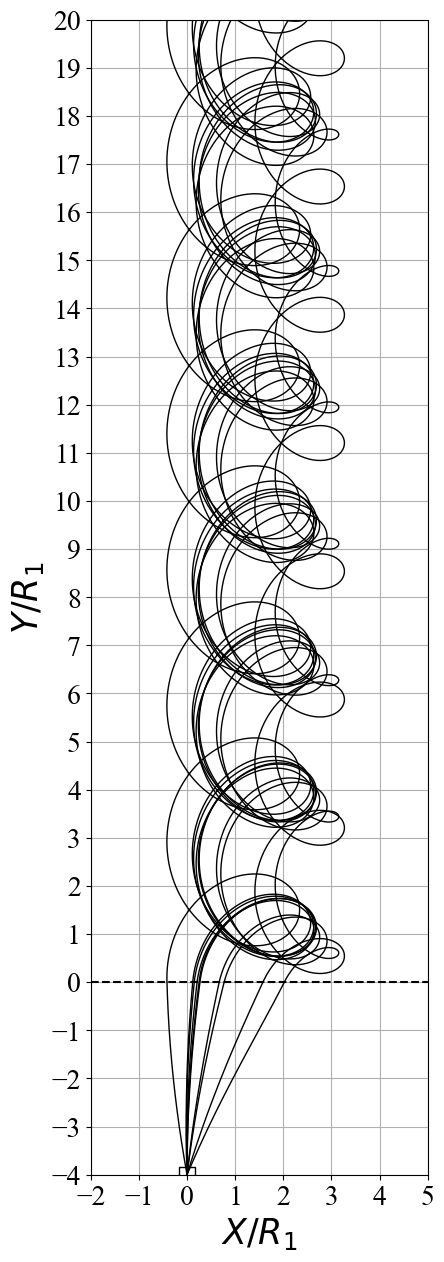

In [40]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

ax.plot(rx/R1, ry/R1, 'k-', lw = 1) 

ax.plot(x0/R1, y0/R1,'sk', markersize=12, markerfacecolor='none', markeredgecolor='black')

ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([y0/R1,20]);
#ax.set_xlim([x0lower,x0upper])
ax.set_xlim([-2,5])

ax.tick_params(axis='both', which='major', labelsize = 20 )

ax.set_xticks(np.arange(-2,5.1,1))
ax.set_yticks(np.arange(-4,20.1,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size=25)
ax.grid(axis='both')
ax.set_aspect(1)

#plt.savefig('SampleTrajectory_07_10_2015_3D_1SIGMA_v1.png',dpi=150, facecolor='w', edgecolor='w', bbox_inches='tight')
#plt.savefig('SampleTrajectory_01_12_2015_2D_1SIGMA_v1.png',dpi=150, facecolor='w', edgecolor='w', bbox_inches='tight')

### c) 

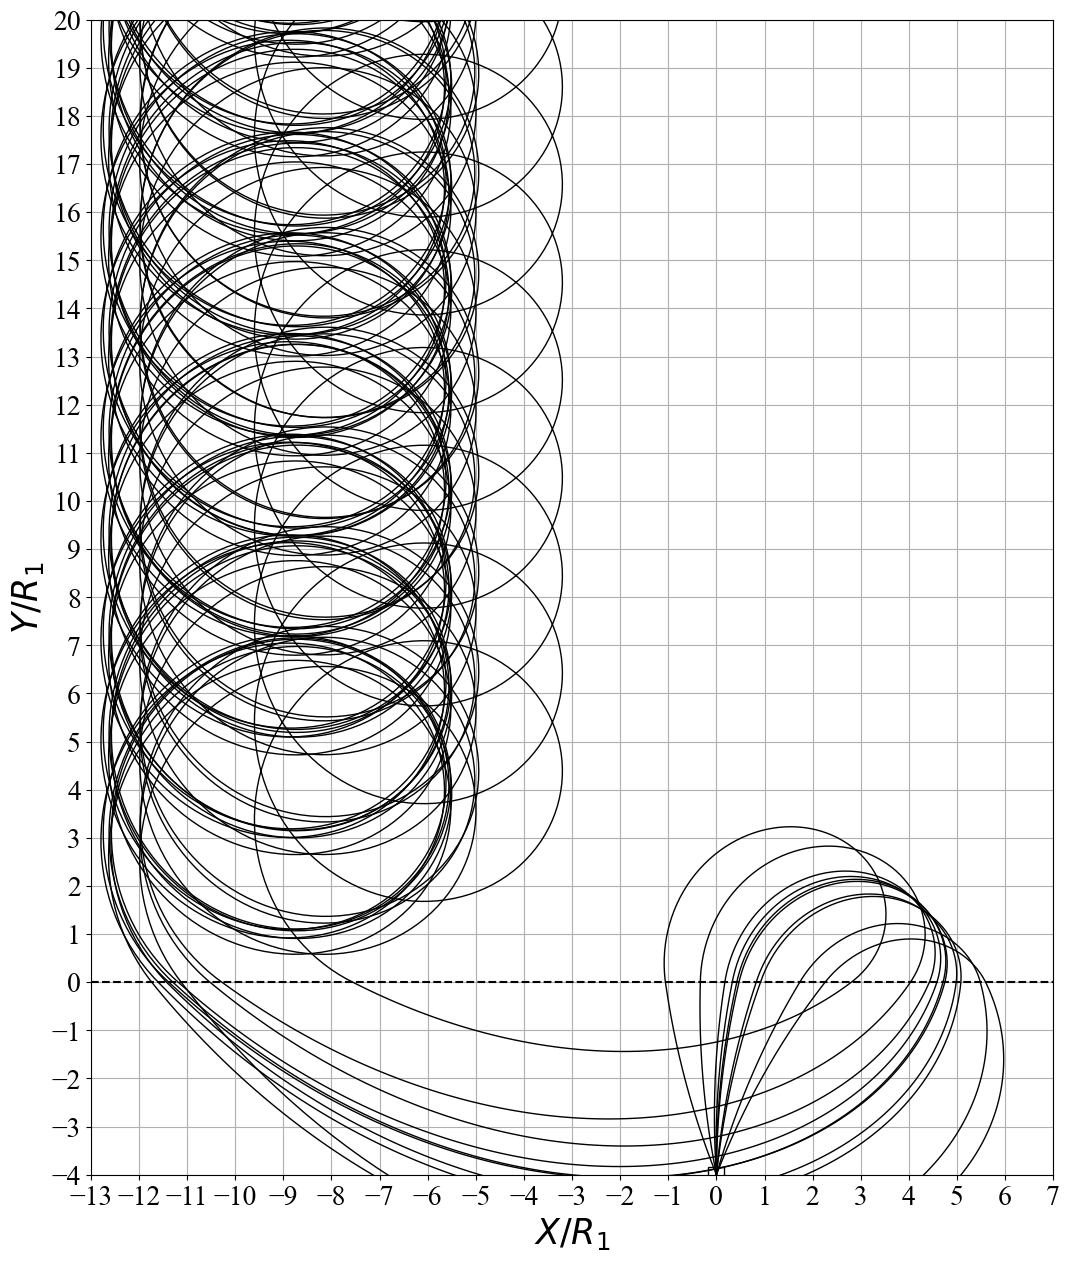

In [54]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

ax.plot(rx/R1, ry/R1, 'k-', lw = 1) 

ax.plot(x0/R1, y0/R1,'sk', markersize=12, markerfacecolor='none', markeredgecolor='black')

ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([y0/R1,20]);
#ax.set_xlim([x0lower,x0upper])
ax.set_xlim([-13,7])

ax.tick_params(axis='both', which='major', labelsize = 20 )

ax.set_xticks(np.arange(-13,7.1,1))
ax.set_yticks(np.arange(-4,20.1,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size=25)
ax.grid(axis='both')
ax.set_aspect(1)

plt.savefig('SampleTrajectory_07_10_2015_3D_5SIGMA_v1.png',dpi=150, facecolor='w', edgecolor='w', bbox_inches='tight')

## Lixo 

In [ ]:
for i in range(8):
    
    RX1 = rx[:,i][ rx[:,i] < 6*R1 ]   
    RY1 = ry[:,i][ rx[:,i] < 6*R1 ]
    
    RX2 = rx[:,i][ rx[:,i] > 6*R1 ]   
    RY2 = ry[:,i][ rx[:,i] > 6*R1 ]
    
    ax.plot(RX1/R1, RY1/R1, 'k-', lw = 1)
    ax.plot(RX2/R1, RY2/R1, 'k-', lw = 1)

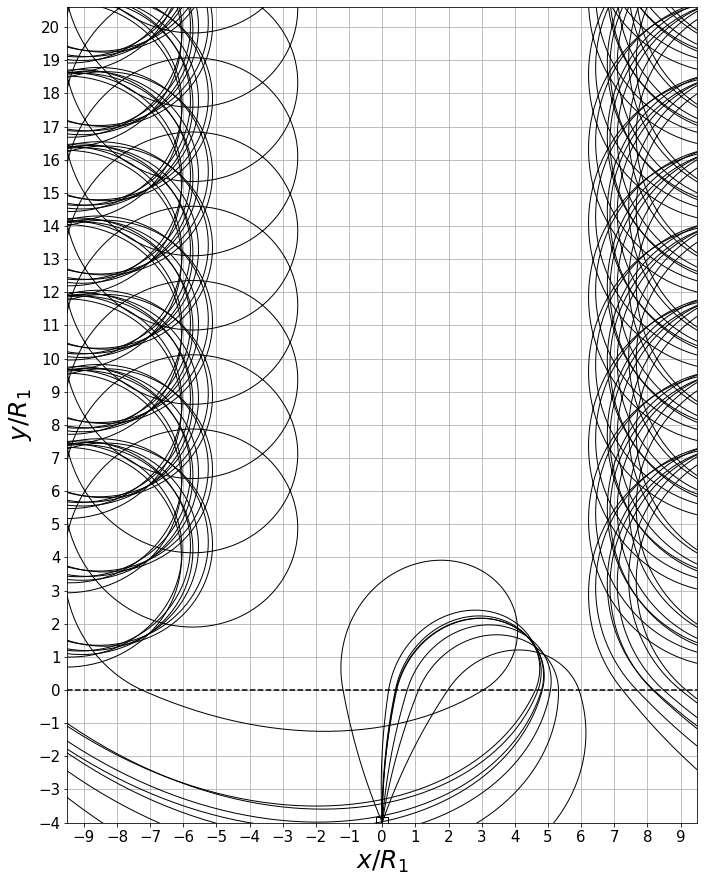

In [40]:
fig,ax = plt.subplots(1,1,figsize=(20,15))

#ax.plot(rx/R1, ry/R1,'k--', ms=1)

for i in range(8):
    
    RX1 = rx[:,i][ rx[:,i] < 6.2*R1 ]   
    RY1 = ry[:,i][ rx[:,i] < 6.2*R1 ]
    
    RX2 = rx[:,i][ rx[:,i] > 6.2*R1 ]   
    RY2 = ry[:,i][ rx[:,i] > 6.2*R1 ]
    
    ax.plot(RX1/R1, RY1/R1, 'k-', lw = 1)
    ax.plot(RX2/R1, RY2/R1, 'k-', lw = 1)

ax.plot(x0/R1, y0/R1,'sk', markersize=12, markerfacecolor='none', markeredgecolor='black')

ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([y0/R1,20.6]);
#ax.set_xlim([x0lower,x0upper-1])

#x.set_xticks(np.arange(-2,5.1,1))
ax.set_xticks(np.arange(-10,10.1,1))
ax.set_yticks(np.arange(-4,20.6,1))

ax.set_xlim([-9.5, 9.5])

ax.set_xlabel(r'$x/R_1$', size=25);ax.set_ylabel(r'$y/R_1$', size=25)
ax.tick_params(axis='both', which='major', labelsize = 15 )
ax.grid(axis='both')
ax.set_aspect(1)

#plt.savefig('SampleTrajectory_07_10_2015_3D.png', bbox_inches='tight')

#plt.savefig('TrajectorySample_07_10_2015_3D_1sigma.png',dpi = 300, bbox_inches='tight')

#plt.savefig('10_SampleTrajectory_07_10_2015_3D_5SIGMA_s.png',dpi = 300, bbox_inches='tight')

plt.savefig('SampleTrajectory_07_12_2015_3D_5SIGMA_v4.png',dpi=150, facecolor='w', edgecolor='w', bbox_inches='tight')

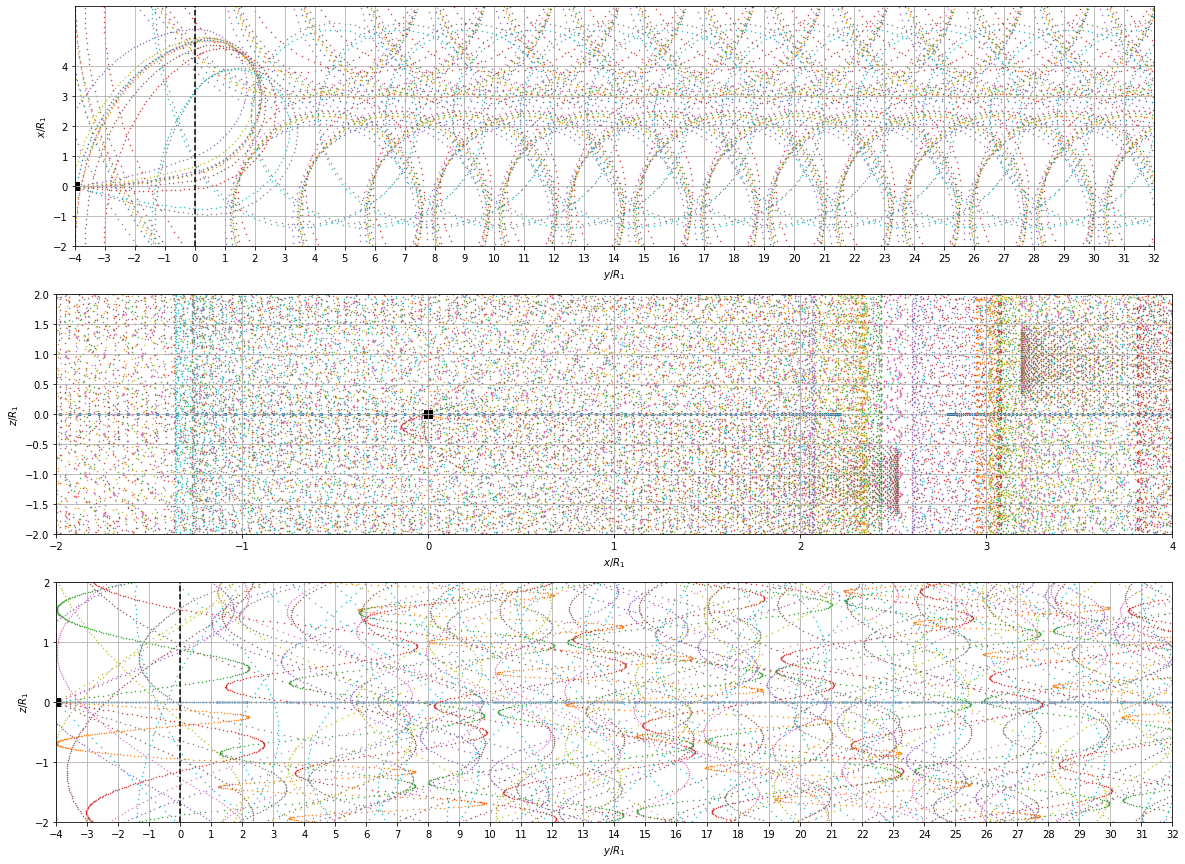

In [20]:
fig, ax = plt.subplots(3, figsize=(20,15))

for i in range(npart):
    
    ax[0].scatter(ry[:,i]/R1, rx[:,i]/R1, marker='.', s=1)
    ax[0].scatter(ry[0,i]/R1, rx[0,i]/R1, s=50, marker='s', color = 'k')

    ax[1].scatter(rx[:,i]/R1, rz[:,i]/R1, marker='.', s=1)
    ax[1].scatter(rx[0,i]/R1, rz[0,i]/R1, s=50, marker='s', color = 'k')
    
    ax[2].scatter(ry[:,i]/R1, rz[:,i]/R1, marker='.', s=1)
    ax[2].scatter(ry[0,i]/R1, rz[0,i]/R1, s=50, marker='s', color = 'k')
    


ax[0].axvline(x=0.0, color='k', linestyle='--')
ax[0].set_ylim([-2, 6]); ax[0].set_xlim([-4,32])
ax[0].set_xticks(np.arange(-4,32.1,1)); ax[0].set_yticks(np.arange(-2,4.1,1))
ax[0].set_xlabel(r'$y/R_1$');ax[0].set_ylabel(r'$x/R_1$')
ax[0].grid(axis='both')
ax[0].set_aspect(1)

ax[1].set_ylim([-2, 2]); ax[1].set_xlim([-2,4])
ax[1].set_xlabel(r'$x/R_1$');ax[1].set_ylabel(r'$z/R_1$')
ax[1].grid(axis='both')

ax[2].axvline(x=0.0, color='k', linestyle='--')
ax[2].set_ylim([-2, 2]); ax[2].set_xlim([-4,32])
ax[2].set_xticks(np.arange(-4,32.1,1)); ax[2].set_yticks(np.arange(-2,2.1,1))
ax[2].set_xlabel(r'$y/R_1$');ax[2].set_ylabel(r'$z/R_1$')
ax[2].grid(axis='both')

#plt.savefig('10_SampleTrajectory_07_10_2015_3D_10SIGMA.png',dpi = 300, bbox_inches='tight')